# Check for any obvious predictors of copulation

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model

from aux import get_seg
from disp import set_font_size, get_line

cc = np.concatenate

SONG_FILE = 'data/simple/c_songs.npy'
COLORS = [(.7, .7, .7), 'b', 'r', (1, .5, 0)]

In [2]:
tmp = np.load(SONG_FILE, allow_pickle=True)[0]
songs = tmp['songs']
dt = tmp['dt']
fps = tmp['fps']

In [3]:
durs = dt*np.array([len(s) for s in songs])
mcpln = durs < durs.max()  # mask for trials ending in copulation

In [4]:
def plot_hists(x, bins=30, c='k', lw=3, fig=None, axs=None, **kwargs):
    if fig is None and axs is None:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)
    cts, bins = np.histogram(x, bins=bins, **kwargs)
    binc = .5*(bins[:-1] + bins[1:])
    axs[0].plot(binc, cts, c=c, lw=lw)
    axs[1].semilogy(binc, cts, c=c, lw=lw)
    axs[2].loglog(binc, cts, c=c, lw=lw)
    
    return fig, axs

Text(11, 17.5, 'Std = 5.25 min')

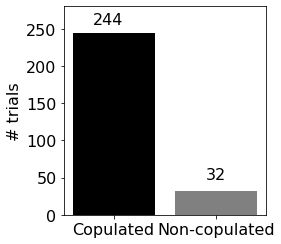

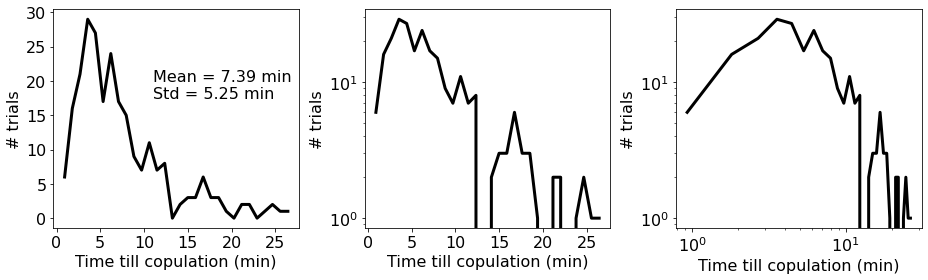

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5), tight_layout=True)
n = len(songs)
n_cpln = mcpln.sum()

ax.bar([0, 1], [n_cpln, n-n_cpln], color=['k', 'gray'], align='center')
ax.set_ylim(0, 280)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Copulated', 'Non-copulated'])
ax.set_ylabel('# trials')
ax.text(-.2, 256, f'{n_cpln}', fontsize=16)
ax.text(.9, 48, f'{n-n_cpln}', fontsize=16)

set_font_size(ax, 16)

t_cpln = durs[mcpln]

fig, axs = plt.subplots(1, 3, figsize=(13, 4), tight_layout=True)
fig, axs = plot_hists(t_cpln/60, bins=30, fig=fig, axs=axs)
for ax in axs:
    ax.set_xlabel('Time till copulation (min)')
    ax.set_ylabel('# trials')
    set_font_size(ax, 16)
axs[0].text(11, 20, f'Mean = {t_cpln.mean()/60:.2f} min', fontsize=16)
axs[0].text(11, 17.5, f'Std = {t_cpln.std()/60:.2f} min', fontsize=16)

In [6]:
p_lbls = ['frc_sng', 'frc_sin', 'frc_psl', 'frc_pfs', 'rto_sin', 'rto_psl', 'rto_pfs', 'mdur_sng', 'mdur_qui', 'mdur_sin', 'mdur_psl', 'mdur_pfs']

predictors = {p_lbl: np.nan * np.zeros(len(songs)) for p_lbl in p_lbls}
predictors['dur'] = np.nan * np.zeros(len(songs))

for cs, s in enumerate(songs):
    predictors['dur'][cs] = dt*len(s)
    predictors['frc_sng'][cs] = np.mean(s > 0)
    predictors['frc_sin'][cs] = np.mean(s == 1)
    predictors['frc_psl'][cs] = np.mean(s == 2)
    predictors['frc_pfs'][cs] = np.mean(s == 3)
    
    predictors['rto_sin'][cs] = np.sum(s == 1)/np.sum(s > 0)
    predictors['rto_psl'][cs] = np.sum(s == 2)/np.sum(s > 0)
    predictors['rto_pfs'][cs] = np.sum(s == 3)/np.sum(s > 0)
    
    _, bds_sng = get_seg(s > 0, min_gap=1)
    predictors['mdur_sng'][cs] = np.mean(bds_sng[:, 1] - bds_sng[:, 0])*dt
    
    _, bds_qui = get_seg(s == 0, min_gap=1)
    predictors['mdur_qui'][cs] = np.mean(bds_qui[:, 1] - bds_qui[:, 0])*dt
    
    _, bds_sin = get_seg(s == 1, min_gap=1)
    predictors['mdur_sin'][cs] = np.mean(bds_sin[:, 1] - bds_sin[:, 0])*dt
    
    _, bds_psl = get_seg(s == 2, min_gap=1)
    predictors['mdur_psl'][cs] = np.mean(bds_psl[:, 1] - bds_psl[:, 0])*dt
    
    _, bds_pfs = get_seg(s == 3, min_gap=1)
    predictors['mdur_pfs'][cs] = np.mean(bds_pfs[:, 1] - bds_pfs[:, 0])*dt

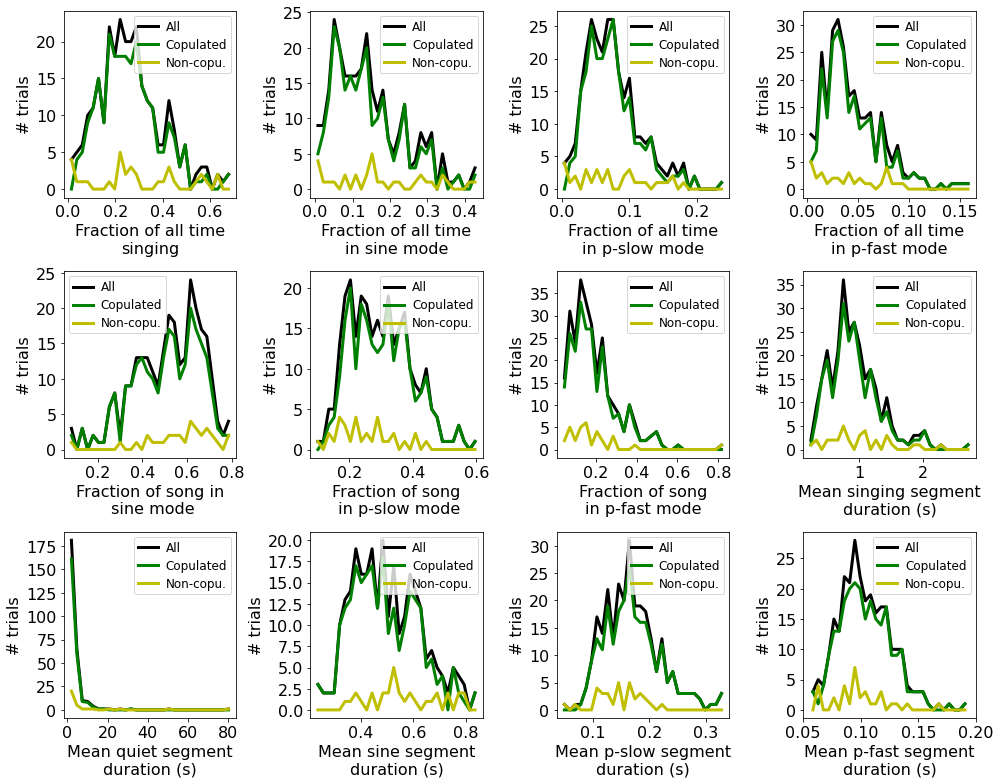

In [7]:
p_lbls_xtd = {
    'frc_sng': 'Fraction of all time\nsinging', 'frc_sin': 'Fraction of all time\nin sine mode', 'frc_psl': 'Fraction of all time\nin p-slow mode', 'frc_pfs': 'Fraction of all time\nin p-fast mode',
    'rto_sin': 'Fraction of song in\n sine mode', 'rto_psl': 'Fraction of song\n in p-slow mode', 'rto_pfs': 'Fraction of song\nin p-fast mode',
    'mdur_sng': 'Mean singing segment\nduration (s)', 'mdur_qui': 'Mean quiet segment\nduration (s)',
    'mdur_sin': 'Mean sine segment\nduration (s)', 'mdur_psl': 'Mean p-slow segment\nduration (s)', 'mdur_pfs': 'Mean p-fast segment\nduration (s)'
}

fig, axs = plt.subplots(3, 4, figsize=(14, 11), tight_layout=True)

for p_lbl, ax in zip(p_lbls, axs.flatten()):
    cts_all, bins = np.histogram(predictors[p_lbl], bins=30)
    cts_cpln, _ = np.histogram(predictors[p_lbl][mcpln], bins=bins)
    cts_fail, _ = np.histogram(predictors[p_lbl][~mcpln], bins=bins)
    
    binc = .5*(bins[:-1] + bins[1:])
    
    ax.plot(binc, cts_all, c='k', lw=3)
    ax.plot(binc, cts_cpln, c='g', lw=3)
    ax.plot(binc, cts_fail, c='y', lw=3)
    
    if p_lbl == 'mdur_pfs':
        ax.set_xlim(.05, .2)
    ax.set_xlabel(p_lbls_xtd[p_lbl])
    ax.set_ylabel('# trials')
    ax.legend(['All', 'Copulated', 'Non-copu.'])
    
set_font_size(axs, 16, legend_font_size=12)

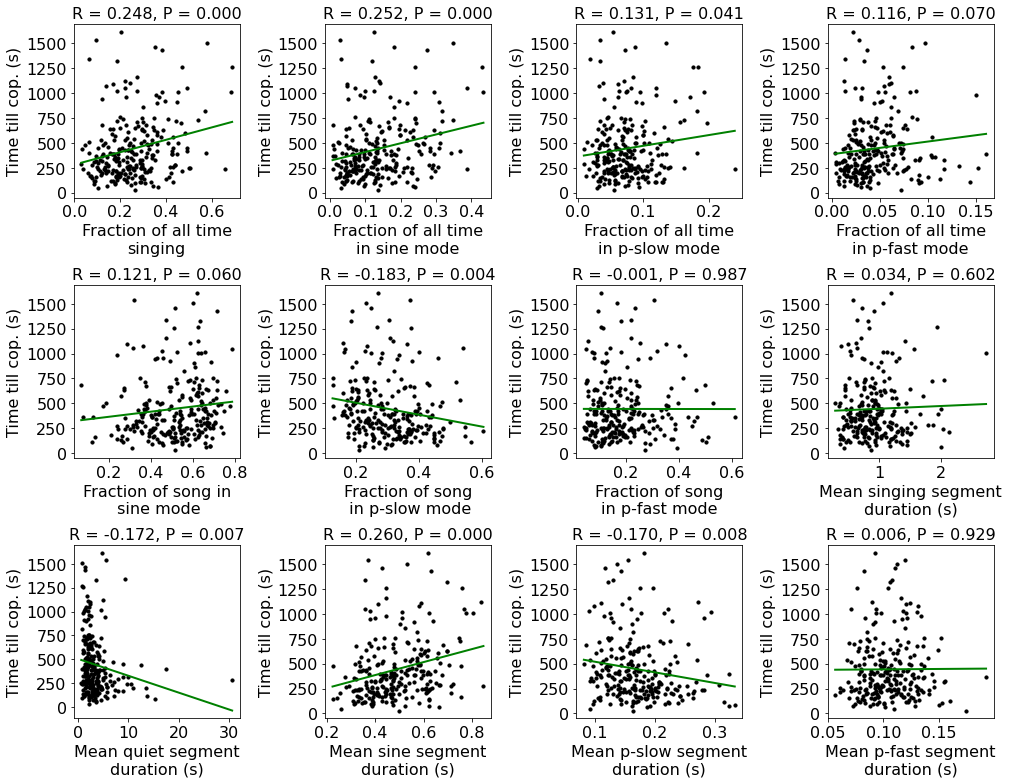

In [8]:
# correlations of predictors w copulation time
fig, axs = plt.subplots(3, 4, figsize=(14, 11), tight_layout=True)

for p_lbl, ax in zip(p_lbls, axs.flatten()):
    x = predictors[p_lbl][mcpln]
    y = predictors['dur'][mcpln]
    
    ax.scatter(x, y, c='k', s=10)
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(x, y)
    
    ax.plot(x_ln, y_ln, c='g', lw=2)
    ax.set_xlabel(p_lbls_xtd[p_lbl])
    ax.set_ylabel('Time till cop. (s)')
    ax.set_title(f'R = {r:.3f}, P = {p:.3f}')
    
    set_font_size(ax, 16)

## Prediction of copulation time from early song patterning

Since non-stationary song can lead to correlations that are not causal

In [9]:
MIN_DUR = 60
mmin_dur = durs >= MIN_DUR  # mask for trials at least 30s long
m = mcpln & mmin_dur

predictors_early = {p_lbl: np.nan * np.zeros(len(songs)) for p_lbl in p_lbls}
predictors_early['dur'] = np.nan * np.zeros(len(songs))

for cs, s in enumerate(songs):
    mt = dt*np.arange(len(s)) < MIN_DUR
    
    predictors_early['dur'][cs] = dt*len(s)
    predictors_early['frc_sng'][cs] = np.mean(s[mt] > 0)
    predictors_early['frc_sin'][cs] = np.mean(s[mt] == 1)
    predictors_early['frc_psl'][cs] = np.mean(s[mt] == 2)
    predictors_early['frc_pfs'][cs] = np.mean(s[mt] == 3)
    
    predictors_early['rto_sin'][cs] = np.sum(s[mt] == 1)/np.sum(s[mt] > 0)
    predictors_early['rto_psl'][cs] = np.sum(s[mt] == 2)/np.sum(s[mt] > 0)
    predictors_early['rto_pfs'][cs] = np.sum(s[mt] == 3)/np.sum(s[mt] > 0)

    if np.sum(s[mt] > 0):
        _, bds_sng = get_seg(s[mt] > 0, min_gap=1)
        predictors_early['mdur_sng'][cs] = np.mean(bds_sng[:, 1] - bds_sng[:, 0])*dt
    else:
        predictors_early['mdur_sng'][cs] = np.nan
    
    if np.sum(s[mt] == 0):
        _, bds_qui = get_seg(s[mt] == 0, min_gap=1)
        predictors_early['mdur_qui'][cs] = np.mean(bds_qui[:, 1] - bds_qui[:, 0])*dt
    else:
        predictors_early['mdur_qui'][cs] = np.nan
    
    if np.sum(s[mt] == 1):
        _, bds_sin = get_seg(s[mt] == 1, min_gap=1)
        predictors_early['mdur_sin'][cs] = np.mean(bds_sin[:, 1] - bds_sin[:, 0])*dt
    else:
        predictors_early['mdur_sin'][cs] = np.nan
    
    if np.sum(s[mt] == 2):
        _, bds_psl = get_seg(s[mt] == 2, min_gap=1)
        predictors_early['mdur_psl'][cs] = np.mean(bds_psl[:, 1] - bds_psl[:, 0])*dt
    else:
        predictors_early['mdur_psl'][cs] = np.nan
    
    if np.sum(s[mt] == 3):
        _, bds_pfs = get_seg(s[mt] == 3, min_gap=1)
        predictors_early['mdur_pfs'][cs] = np.mean(bds_pfs[:, 1] - bds_pfs[:, 0])*dt
    else:
        predictors_early['mdur_pfs'][cs] = np.nan

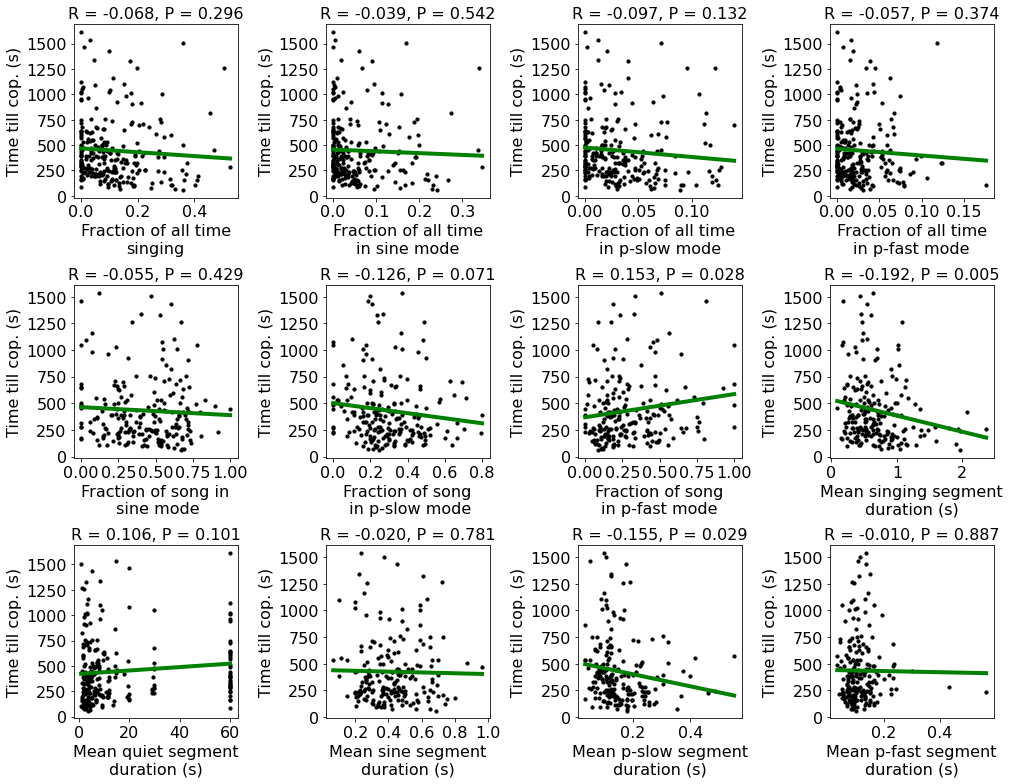

In [10]:
fig, axs = plt.subplots(3, 4, figsize=(14, 11), tight_layout=True)

for p_lbl, ax in zip(p_lbls, axs.flatten()):
    x = predictors_early[p_lbl][m]
    y = predictors_early['dur'][m]
    
    ax.scatter(x, y, c='k', s=10)
    x_ln, y_ln, (slp, icpt, r, p, stderr) = get_line(x, y)
    
    ax.plot(x_ln, y_ln, c='g', lw=4)
    ax.set_xlabel(p_lbls_xtd[p_lbl])
    ax.set_ylabel('Time till cop. (s)')
    ax.set_title(f'R = {r:.3f}, P = {p:.3f}')
    
    set_font_size(ax, 16)